In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, least_squares, fmin_slsqp, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM
from joblib import Parallel, delayed

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1_log(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    L1 = (np.sum(np.abs(ir-er))/n) + (np.sum(np.abs(ij-ej))/n)
    if np.isnan(L1):
        return np.inf
    return L1


def otto_model_L2_log(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    e = np.concatenate((ir - er, ij - ej))
    L2 = np.dot(e.T, e)/n
    if np.isnan(L2):
        return np.inf
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    if np.isnan(L2):
        return np.inf
    return L2


def otto_model_L1_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    e = np.sum((np.abs((zr-np.real(ztot))))/(np.abs(zmag))) + \
        np.sum((np.abs((zj-np.abs(np.imag(ztot)))))/(np.abs(zmag)))

    L1 = e / n
    if np.isnan(L1):
        return np.inf
    return L1


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    lstrings = ['Log10 L1', 'Log10 L2', r"L1 weighted", "L2 weighted"]
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_k)

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label=lstrings[0])
    plt.plot(zr_l2, zj_l2, 's-', label=lstrings[1])
    plt.plot(zr_linf, zj_linf, '>-', label=lstrings[2])
    plt.plot(zr_lk, zj_lk, '<-', label=lstrings[3])
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.legend()
    plt.savefig('figs/' + title + 'rj_nolog.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label=lstrings[0])
    plt.plot(zr_l2, zj_l2, 's-', label=lstrings[1])
    plt.plot(zr_linf, zj_linf, '>-', label=lstrings[2])
    plt.plot(zr_lk, zj_lk, '<-', label=lstrings[3])
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'rj.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zj_l1, 'o-', label=lstrings[0])
    plt.plot(f, zj_l2, 's-', label=lstrings[1])
    plt.plot(f, zj_linf, '>-', label=lstrings[2])
    plt.plot(f, zj_lk, '<-', label=lstrings[3])
    plt.plot(f, zj, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'j.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zr_l1, 'o-', label=lstrings[0])
    plt.plot(f, zr_l2, 's-', label=lstrings[1])
    plt.plot(f, zr_linf, '>-', label=lstrings[2])
    plt.plot(f, zr_lk, '<-', label=lstrings[3])
    plt.plot(f, zr, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'r.png', dpi=300, bbox_inches='tight')
    
    # residual plots
    plt.figure()
    plt.title(title)
    plt.plot(f, (zj-zj_l1)/zj, 'o-', label=lstrings[0])
    plt.plot(f, (zj-zj_l2)/zj, 's-', label=lstrings[1])
    plt.plot(f, (zj-zj_linf)/zj, '>-', label=lstrings[2])
    plt.plot(f, (zj-zj_lk)/zj, '<-', label=lstrings[3])
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'j_resid.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, (zr-zr_l1)/zr, 'o-', label=lstrings[0])
    plt.plot(f, (zr-zr_l2)/zr, 's-', label=lstrings[1])
    plt.plot(f, (zr-zr_linf)/zr, '>-', label=lstrings[2])
    plt.plot(f, (zr-zr_lk)/zr, '<-', label=lstrings[3])
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'r_resid.png', dpi=300, bbox_inches='tight')
    plt.show()

    # real residuals
    # er = zr - zr_x
    # imaginary residuals
    # ej = zj - zj_x

    # plt.figure()
    # plt.title(title)
    # plt.semilogx(f, er, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Real residuals')
    # plt.grid()

    # plt.figure()
    # ptl.title(title)
    # plt.semilogx(f, ej, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Imaginary residuals')
    # plt.grid()
    # plt.show()


def my_opt_fun(obj_function):
    # run differential evolution
#     solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=25,
#                              limits=bounds, minimize=True)
    solver = pyfde.JADE(obj_function, n_dim=5, n_pop=25,
                        limits=bounds, minimize=True)
    solver.c = np.random.random()
    solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()*2.0
    # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
    # polish with constrained nelder mead simplex optimization
    res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                           full_output=True, xtol=1e-15, ftol=1e-15)
    # if polish better save polish results
    if res_cnm['fopt'] < fit:
        opts = res_cnm['fopt']
        results_x = res_cnm['xopt']
        print('Polish was better')
    else:
        opts = fit
        results_x = best
        print('Polish did not help')
    return np.append(results_x, opts)


def opt_routine(obj_function, runs=100, n_proc=8):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun)(obj_function) for _ in range(runs))  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
#     print('Paramters:', results_x)
    print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Best Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt


# Optimization on artifical solution
Run the optimization on known paramter values

Optimization runtime 74.0758 seconds
Set of optima: [3.12383541e-11 3.12383541e-11 3.12383541e-11 3.12383523e-11
 3.12383523e-11 3.12383523e-11 3.12383595e-11 3.12383523e-11
 3.12383523e-11 3.12383541e-11 3.12383523e-11 3.12383523e-11
 3.12383612e-11 3.12383968e-11 3.12383523e-11 3.12383523e-11
 3.12383523e-11 3.12383523e-11 3.12383523e-11 3.12383523e-11
 3.12383541e-11 3.12383523e-11 3.12383630e-11 3.12383666e-11
 3.12383843e-11 3.12383666e-11 3.12383523e-11 3.12383523e-11
 3.12383523e-11 3.12383523e-11 3.12383523e-11 3.12383541e-11
 3.12383523e-11 3.12383541e-11 3.12383523e-11 3.12383541e-11
 3.12383523e-11 3.12383523e-11 3.12383612e-11 3.12383523e-11
 3.12383541e-11 3.12383523e-11 3.12383523e-11 3.12383523e-11
 3.12383541e-11 3.12383666e-11 3.12383523e-11 3.12383541e-11
 3.12383825e-11 3.12383541e-11 3.12383630e-11 3.12383541e-11
 3.12383523e-11 3.12383612e-11 3.12383523e-11 3.12383523e-11
 3.12383541e-11 3.12383523e-11 3.12383577e-11 3.12383523e-11
 3.12383523e-11 3.12383843e-11 3.

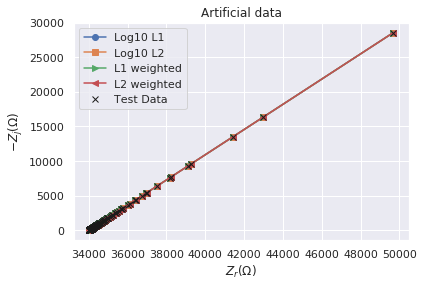

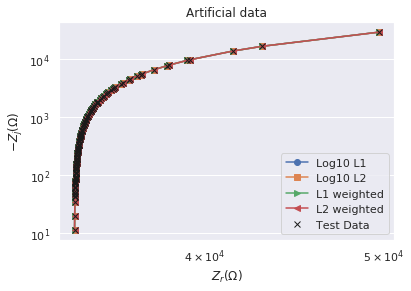

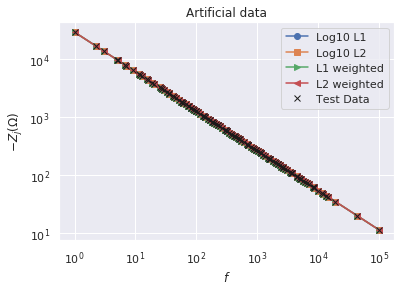

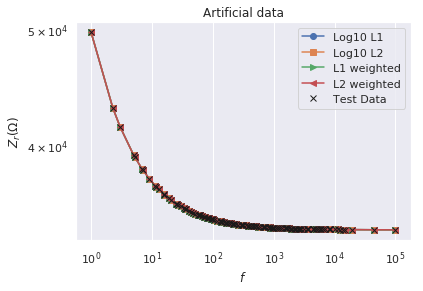

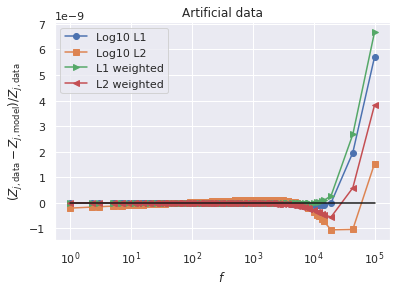

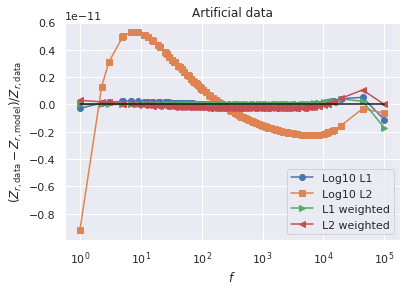

In [2]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[3, 1] = 1e30
bounds[2, 0] = 1e-2
bounds[4, 0] = 1e-10
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

dataset = pd.read_csv(data_prefix+data_list[0])
f = dataset.values[:, 0]
# sort the f values
f_ind = np.argsort(f)
f = f[f_ind]
n = len(f)


# generate fake results
zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])

# remove nans in zr and zj experimental data
inds = np.where(np.isnan(np.log10(zj)))
zj = np.delete(zj, inds)
zr = np.delete(zr, inds)
f = np.delete(f, inds)
n = len(f)

# run log10 optimizations
xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

# run normal optimizations
xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
     'Artificial data')

# Run optimization on Blue Test Data

Optimization runtime 66.5589 seconds
Set of optima: [0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833444 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833453 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833454 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.0183340

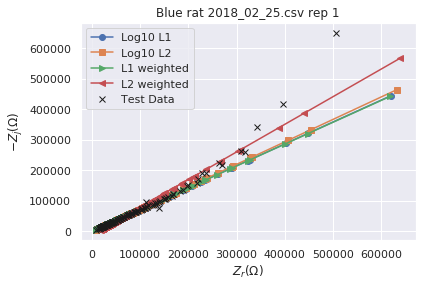

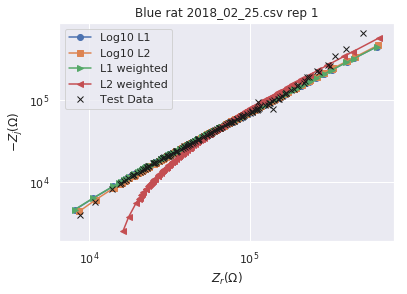

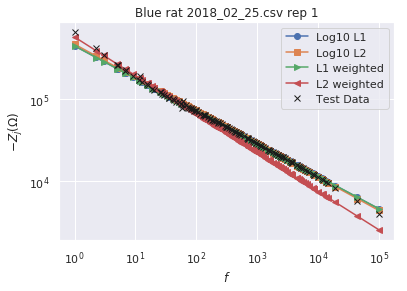

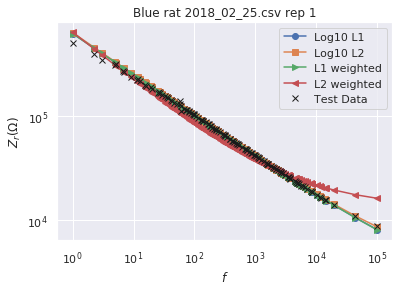

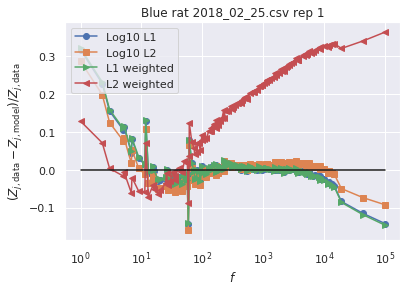

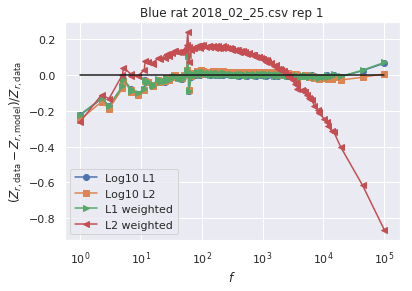

Optimization runtime 67.3861 seconds
Set of optima: [0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.0167800

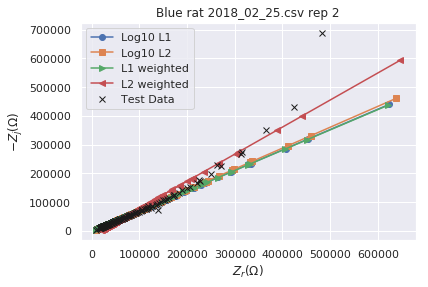

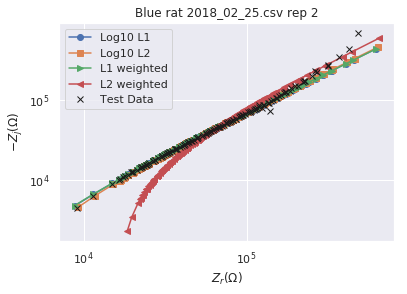

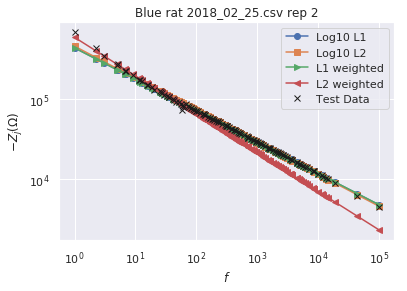

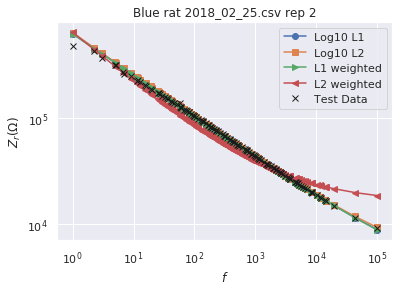

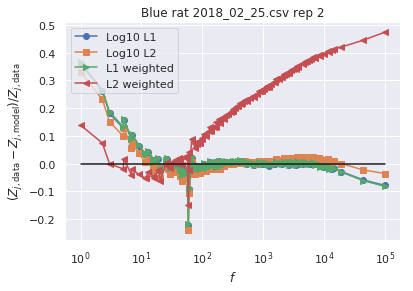

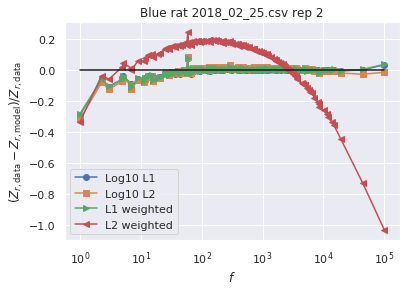

Optimization runtime 85.3488 seconds
Set of optima: [0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.07523678 0.0752254  0.0752254  0.0752254  0.0752254  0.07523678
 0.07523678 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.07523678 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.07523678 0.0752254  0.0752254
 0.0752254  0.0752254  

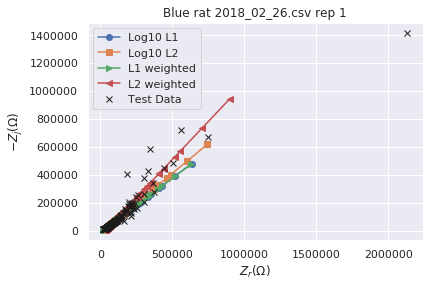

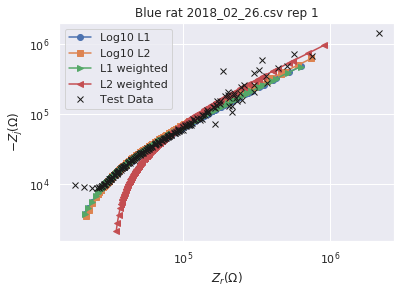

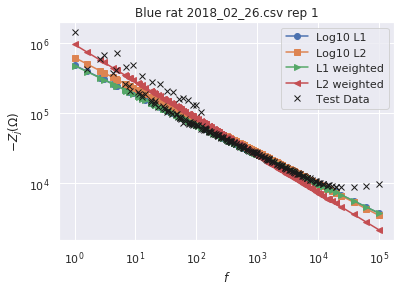

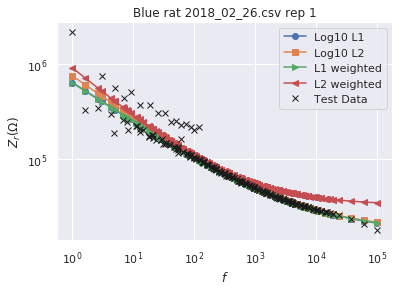

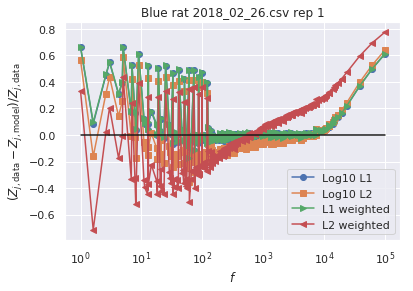

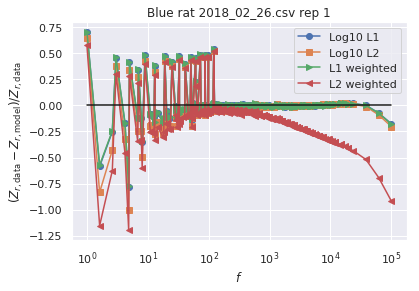

Optimization runtime 81.7420 seconds
Set of optima: [0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.07523681 0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0.0752254  0.0752254  0.0752254  0.0752254
 0.0752254  0.0752254  0

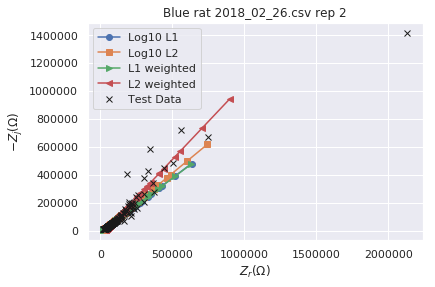

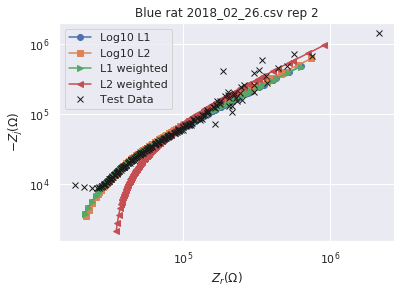

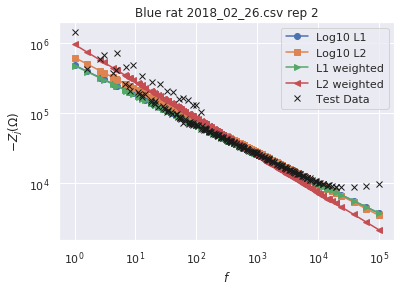

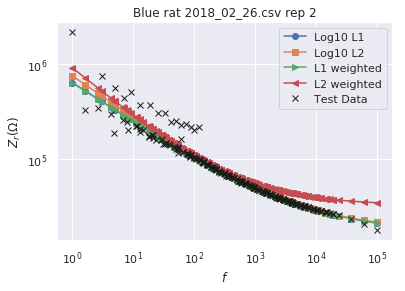

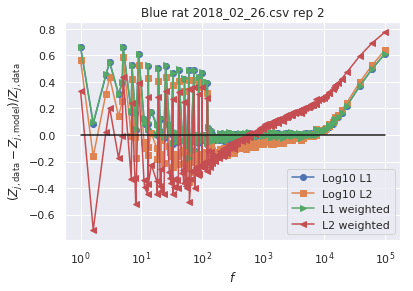

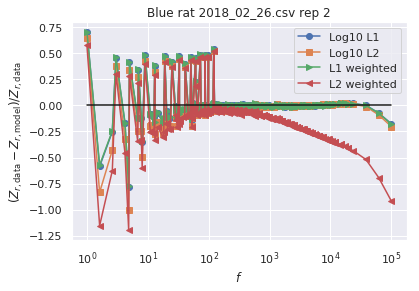

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10


Optimization runtime 86.0399 seconds
Set of optima: [0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282 0.1992282
 0.1992282 0.1992282 0.19

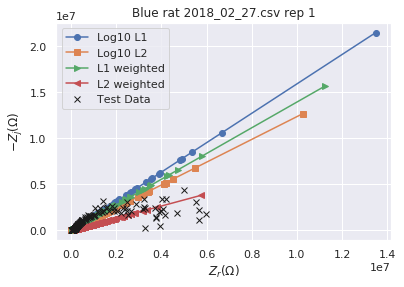

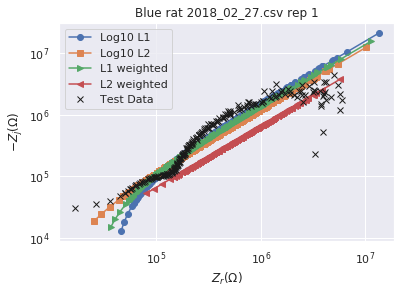

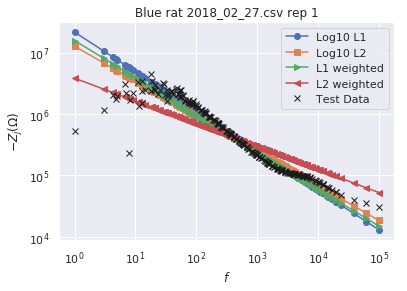

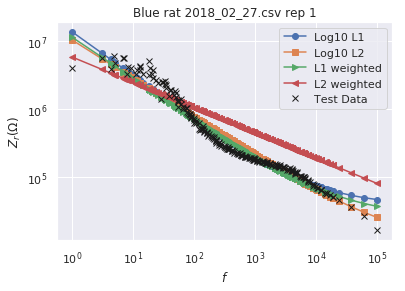

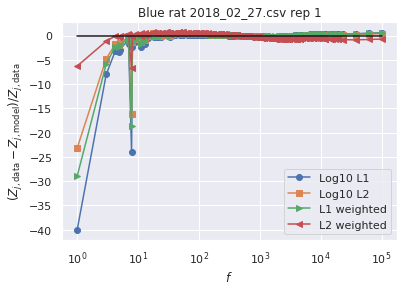

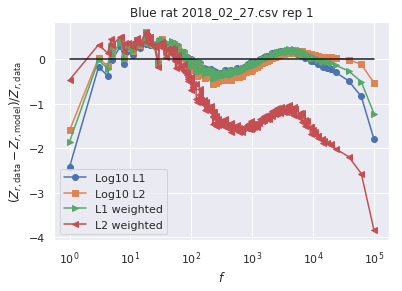

Optimization runtime 82.6840 seconds
Set of optima: [0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.20921125 0.2092111  0.20921405 0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.2092111  0.2092111  0.2092111  0.2092111  0.2092111  0.2092111
 0.20921163 0.2092111  0

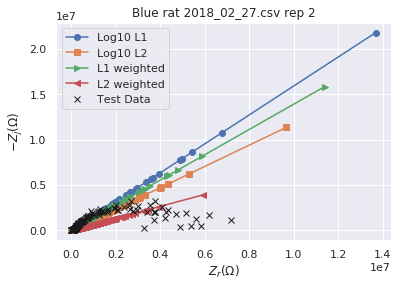

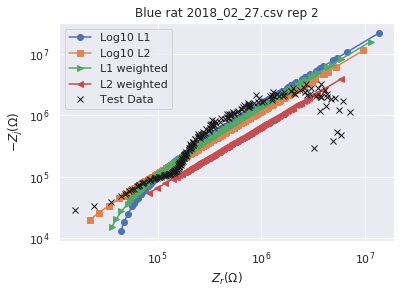

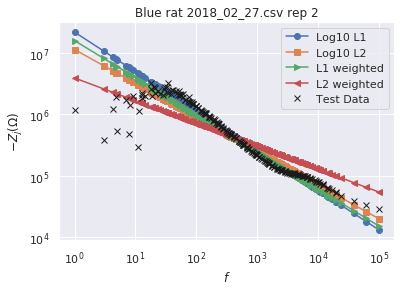

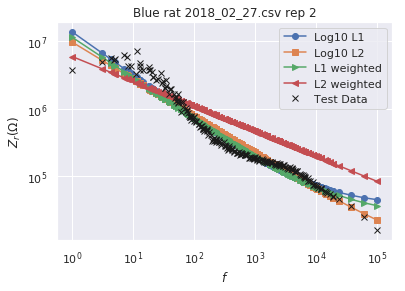

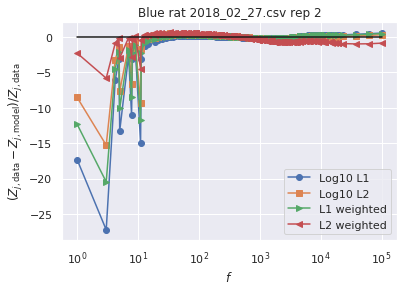

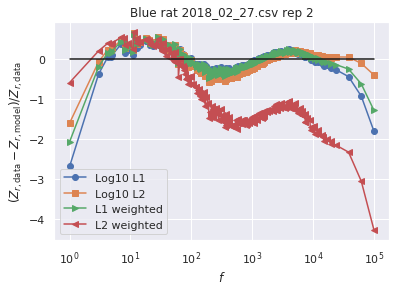

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log10


Optimization runtime 81.3848 seconds
Set of optima: [0.18452205 0.18452205 0.18452208 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452206 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205 0.18452205
 0.1845220

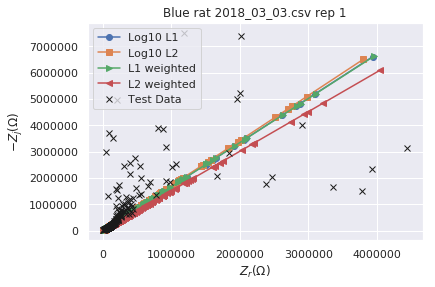

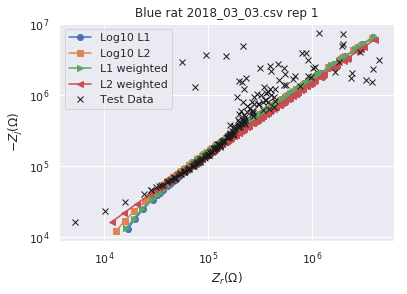

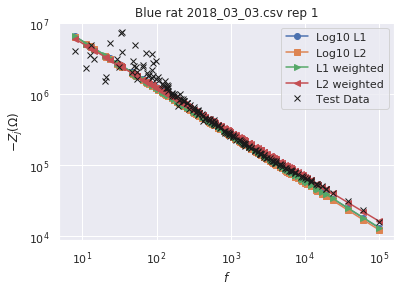

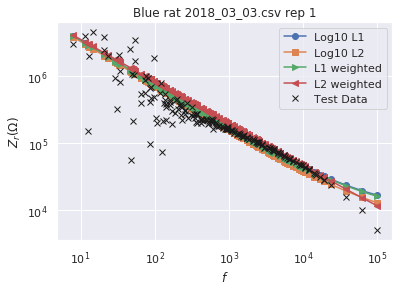

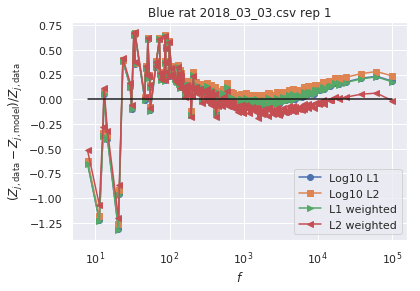

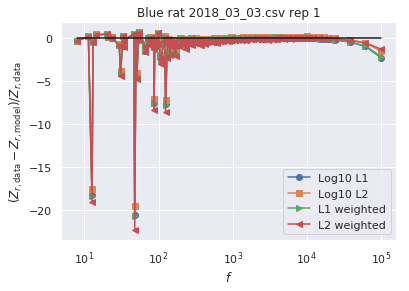

Optimization runtime 80.8087 seconds
Set of optima: [0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223 0.18628223
 0.1862822

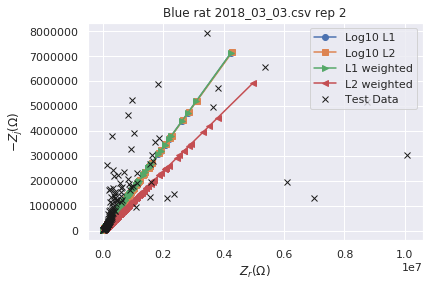

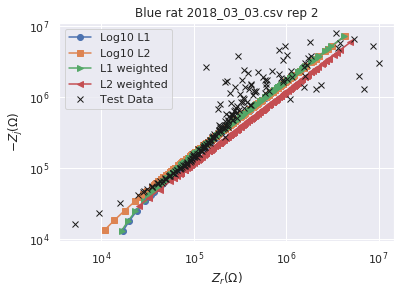

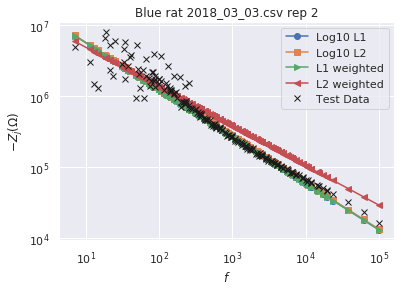

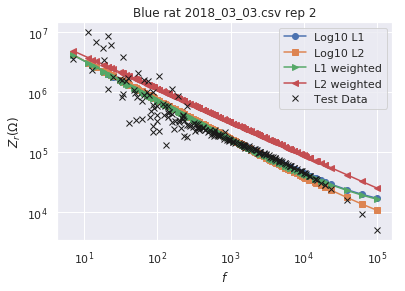

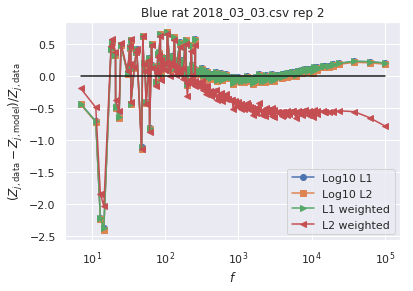

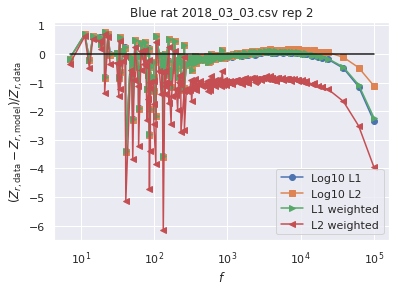

Optimization runtime 74.2911 seconds
Set of optima: [0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.09558193
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  0.0955819  0.0955819  0.0955819  0.0955819
 0.0955819  0.0955819  

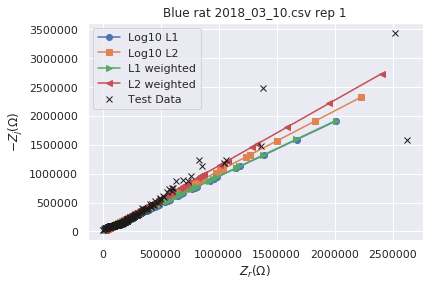

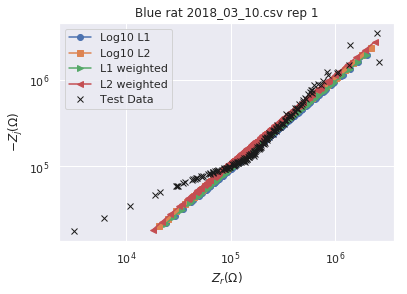

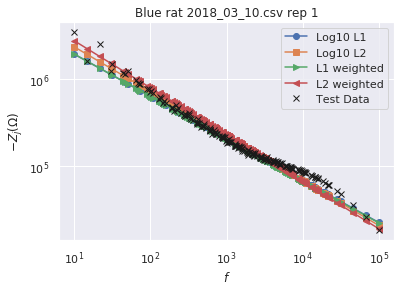

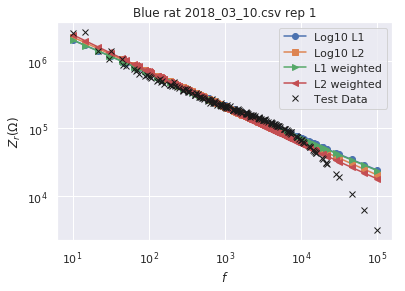

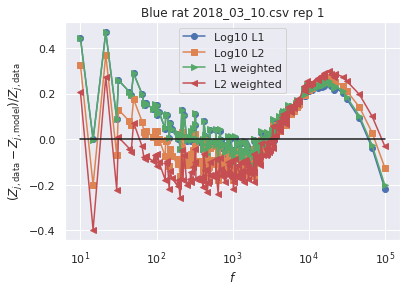

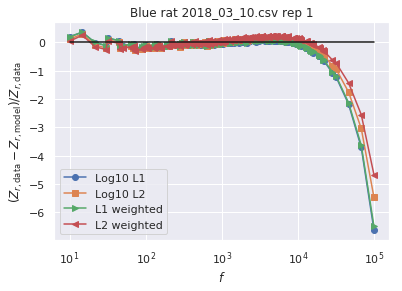

Optimization runtime 74.1039 seconds
Set of optima: [0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590383 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590383
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307 0.10590307
 0.1059030

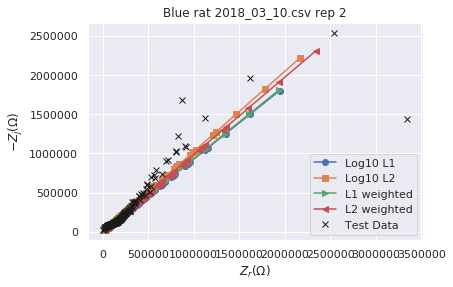

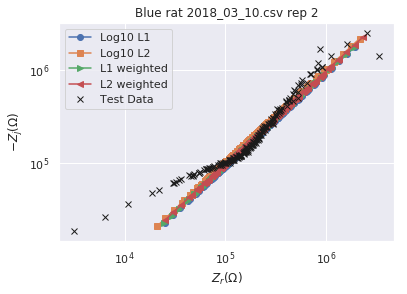

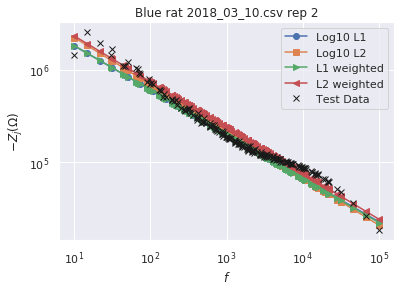

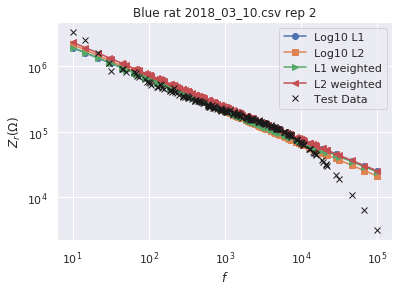

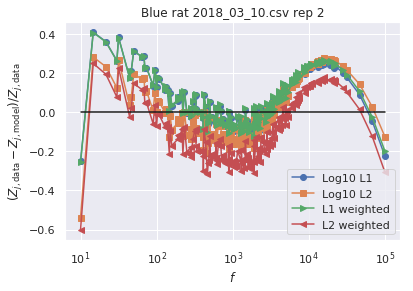

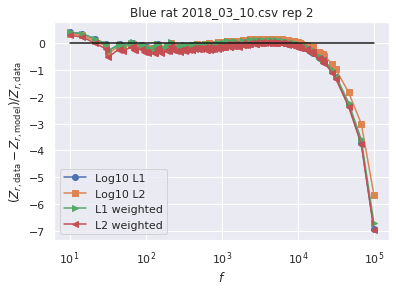

Stored 'res_l1' (ndarray)
Stored 'res_l2' (ndarray)
Stored 'res_lk1' (ndarray)
Stored 'res_lk2' (ndarray)
Stored 'l1_params' (list)
Stored 'l1_opts' (list)
Stored 'l2_params' (list)
Stored 'l2_opts' (list)
Stored 'lk1_params' (list)
Stored 'lk1_opts' (list)
Stored 'lk2_params' (list)
Stored 'lk2_opts' (list)


In [3]:
# optimization bounds
bounds = np.array(((1e-2, 1e1),
                  (1e-2, 1e1),
                  (1e0, 1e4),
                  (1e0, 1e4),
                  (1e0, 1e3)))

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_lk1 = np.zeros((10, 6))
res_lk2 = np.zeros((10, 6))

l1_params = []
l1_opts = []
l2_params = []
l2_opts = []
lk1_params = []
lk1_opts = []
lk2_params = []
lk2_opts = []

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        
        # sort the zr zj and f values
        f_ind = np.argsort(f)
        f = f[f_ind]
        zr = zr[f_ind]
        zj = zj[f_ind]

        # remove nans in zr and zj experimental data
        inds = np.where(np.isnan(np.log10(zj)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        inds = np.where(np.isnan(np.log10(zr)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        n = len(f)

        # run log10 optimizations
        xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
        xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

        # run normal optimizations
        xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
        xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

        # # save the results into the array
        res_l1[ind*2 + i, :5] = x_l1
        res_l1[ind*2 + i, 5] = opt_l1
        res_l2[ind*2 + i, :5] = x_l2
        res_l2[ind*2 + i, 5] = opt_l2
        res_lk1[ind*2 + i, :5] = x_lk1
        res_lk1[ind*2 + i, 5] = opt_lk1
        res_lk2[ind*2 + i, :5] = x_lk2
        res_lk2[ind*2 + i, 5] = opt_lk2
        
        # append results
        l1_params.append(xs_l1)
        l1_opts.append(opts_l1)
        l2_params.append(xs_l2)
        l2_opts.append(opts_l2)
        lk1_params.append(xs_lk1)
        lk1_opts.append(opts_lk1)
        lk2_params.append(xs_lk2)
        lk2_opts.append(opts_lk2)
        
        plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
             'Blue rat ' + data + ' rep ' + str(i+1))

%store res_l1
%store res_l2
%store res_lk1
%store res_lk2
%store l1_params
%store l1_opts
%store l2_params
%store l2_opts
%store lk1_params
%store lk1_opts
%store lk2_params
%store lk2_opts

# Example results for just one curve

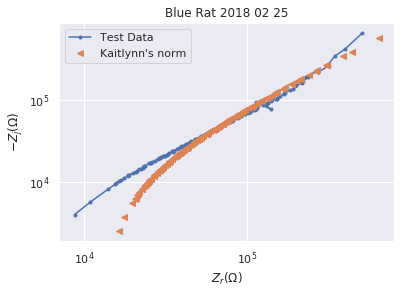

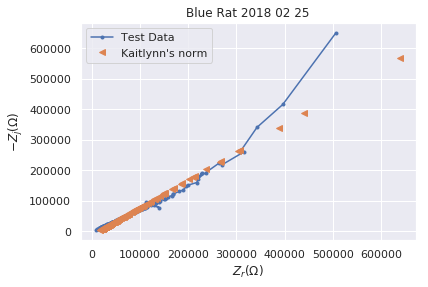

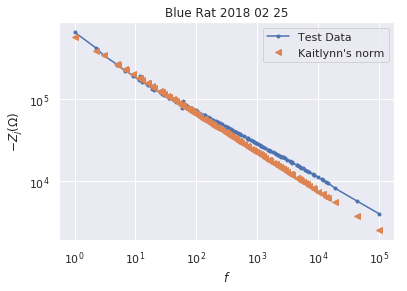

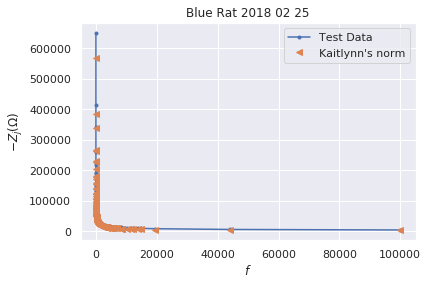

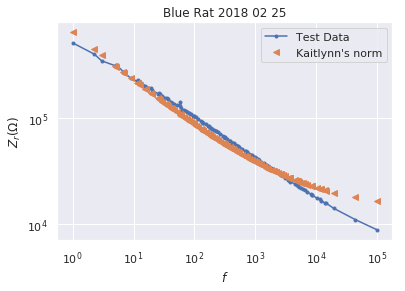

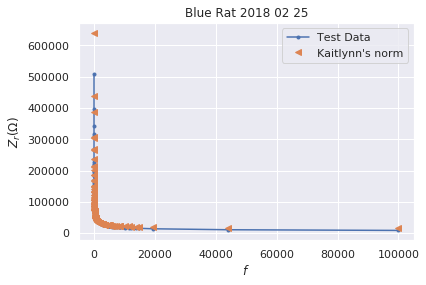

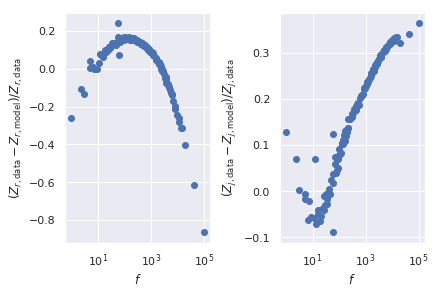

In [4]:
# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

# plot Kaitlynn's norm results
dataset = pd.read_csv(data_prefix+data_list[0])
j = 0*3
f = dataset.values[:, j]
n = len(f)
zr = dataset.values[:, j+1]
zj = dataset.values[:, j+2]
zr_lk, zj_lk = otto_model_create_data(res_lk2[0, :5])
title = 'Blue Rat 2018 02 25'
plt.figure()
plt.title(title)
plt.plot(zr, zj, '.-', label='Test Data')
plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logrj.png', dpi=300, bbox_inches='tight')


plt.figure()
plt.title(title)
plt.plot(zr, zj, '.-', label='Test Data')
plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'rj.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj, '.-', label='Test Data')
plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logj.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj, '.-', label='Test Data')
plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'j.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr, '.-', label='Test Data')
plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logr.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr, '.-', label='Test Data')
plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'r.png', dpi=300, bbox_inches='tight')
plt.show()

# new plots based on Kaitlynn's suggestion
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(f, (zr-zr_lk)/zr, 'o')
ax[0].set_xscale('log')
ax[0].set_xlabel('$f$')
ax[0].set_ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')

ax[1].plot(f, (zj-zj_lk)/zj, 'o')
ax[1].set_xscale('log')
ax[1].set_xlabel('$f$')
ax[1].set_ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [5]:
columns = ['alpha CPE phase factor','K CPE magnitude factor', 'ren encapsulation resistance (k ohm)', 'rex extracellular resistance (k ohm)', 'am membrane area in cm**2', 'objective value']
index_rows = ['blue rat 2018_02_25 rep 1', 'blue rat 2018_02_25 rep 2', 'blue rat 2018_02_26 rep 1', 'blue rat 2018_02_26 rep 2', 'blue rat 2018_02_27 rep 1', 'blue rat 2018_02_27 rep 2',
             'blue rat 2018_03_03 rep 1', 'blue rat 2018_03_03 rep 2', 'blue rat 2018_03_10 rep 1', 'blue rat 2018_03_10 rep 2']
pd_l1 = pd.DataFrame(res_l1, index=index_rows, columns=columns)
pd_l2 = pd.DataFrame(res_l2, index=index_rows, columns=columns)
pd_lk1 = pd.DataFrame(res_lk1, index=index_rows, columns=columns)
pd_lk2 = pd.DataFrame(res_lk2, index=index_rows, columns=columns)

# Log10 L1 Norm

In [6]:
pd_l1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.396616,0.632998,1.715427,1.000000,1000.0,0.018334
blue rat 2018_02_25 rep 2,0.392040,0.638104,2.016196,1.000000,1000.0,0.016780
blue rat 2018_02_26 rep 1,0.420727,0.590611,16.805148,9999.999197,1.0,0.075225
blue rat 2018_02_26 rep 2,0.420727,0.590611,16.805148,10000.000000,1.0,0.075225
blue rat 2018_02_27 rep 1,0.644302,0.012066,38.091529,9999.964970,1.0,0.199228
blue rat 2018_02_27 rep 2,0.643553,0.011933,36.050974,9999.989771,1.0,0.209211
blue rat 2018_03_03 rep 1,0.658651,0.010000,9.076258,10000.000000,1.0,0.184522
blue rat 2018_03_03 rep 2,0.658586,0.010000,9.440625,9999.985205,1.0,0.186282
blue rat 2018_03_10 rep 1,0.484242,0.048473,1.000000,9999.993979,1.0,0.095582
blue rat 2018_03_10 rep 2,0.476208,0.052525,1.000000,9999.994901,1.0,0.105903


# Log10 L2 Norm

In [7]:
pd_l2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.404298,0.607267,2.667784,1.000000,1000.000000,0.027255
blue rat 2018_02_25 rep 2,0.399496,0.611805,2.888102,9999.999843,1.000000,0.029531
blue rat 2018_02_26 rep 1,0.448928,0.460258,18.024435,9999.998374,1.000000,0.123804
blue rat 2018_02_26 rep 2,0.448928,0.460258,18.024435,9999.999941,1.000000,0.123804
blue rat 2018_02_27 rep 1,0.567655,0.021620,10.381902,10000.000000,1.000000,0.222964
blue rat 2018_02_27 rep 2,0.550747,0.024416,5.117479,10000.000000,1.000000,0.241928
blue rat 2018_03_03 rep 1,0.664013,0.010000,5.898179,9999.994930,1.000000,0.255186
blue rat 2018_03_03 rep 2,0.656750,0.010000,2.866831,9999.996948,1.000000,0.221608
blue rat 2018_03_10 rep 1,0.513884,0.036981,1.000000,6730.414127,999.999991,0.119470
blue rat 2018_03_10 rep 2,0.507927,0.039386,1.000000,5944.157032,999.999973,0.124835


# L1 Kaitlynn's Norm

In [8]:
pd_lk1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.395822,0.636244,1.635208,1.000000,1000.0,0.028404
blue rat 2018_02_25 rep 2,0.391128,0.642557,1.941629,1.000019,1000.0,0.025856
blue rat 2018_02_26 rep 1,0.419697,0.597584,16.841586,10000.000000,1.0,0.092807
blue rat 2018_02_26 rep 2,0.419697,0.597584,16.841586,10000.000000,1.0,0.092807
blue rat 2018_02_27 rep 1,0.605047,0.017043,26.134184,9999.971668,1.0,0.316502
blue rat 2018_02_27 rep 2,0.603530,0.016925,25.200614,9999.989755,1.0,0.324562
blue rat 2018_03_03 rep 1,0.657963,0.010000,8.343348,9999.999990,1.0,0.214018
blue rat 2018_03_03 rep 2,0.658586,0.010000,8.815289,9999.997709,1.0,0.239006
blue rat 2018_03_10 rep 1,0.485873,0.048173,1.000000,10000.000000,1.0,0.147261
blue rat 2018_03_10 rep 2,0.479070,0.051893,1.000000,10000.000000,1.0,0.162995


# L2 Kaitlynn's (original) norm

In [9]:
pd_lk2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance (k ohm),rex extracellular resistance (k ohm),am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.468788,0.499736,13.451228,9999.991875,1.000000,1.368560e+09
blue rat 2018_02_25 rep 2,0.480462,0.477382,16.049754,9999.991909,1.000000,2.629586e+09
blue rat 2018_02_26 rep 1,0.527150,0.295559,33.334600,9999.807409,1.000000,7.581268e+11
blue rat 2018_02_26 rep 2,0.527150,0.295559,33.334601,9999.826194,1.000000,7.581268e+11
blue rat 2018_02_27 rep 1,0.372769,0.072849,1.000000,1.000000,1000.000000,6.240911e+13
blue rat 2018_02_27 rep 2,0.371403,0.071331,1.000000,1.000002,1000.000000,6.626585e+13
blue rat 2018_03_03 rep 1,0.627116,0.011898,1.000000,1.000000,999.999973,5.219080e+13
blue rat 2018_03_03 rep 2,0.555364,0.015850,1.000000,1.000003,999.999997,9.787641e+13
blue rat 2018_03_10 rep 1,0.540915,0.029250,1.560395,9999.844098,1.000000,1.441838e+11
blue rat 2018_03_10 rep 2,0.496031,0.039029,1.000000,1.000000,1000.000000,3.629173e+11


In [10]:
%store -r

In [11]:
lstrings = ['Log10 L1', 'Log10 L2', r"L1 weighted", "L2 weighted"]

for i, j in enumerate(index_rows):
    print('===================================')
    print(j)
    res = res_lk2
    print(lstrings[3], ' & {0:.3E}'.format(res[i, 0]), ' & {0:.3E}'.format(res[i, 1]), ' & {0:.3E}'.format(res[i, 2]), ' & {0:.3E}'.format(res[i, 3]), ' & {0:.3E}'.format(res[i, 4]), ' & {0:.3E}'.format(res[i, 5]), r'\\')
    res = res_lk1
    print(lstrings[2], ' & {0:.3E}'.format(res[i, 0]), ' & {0:.3E}'.format(res[i, 1]), ' & {0:.3E}'.format(res[i, 2]), ' & {0:.3E}'.format(res[i, 3]), ' & {0:.3E}'.format(res[i, 4]), ' & {0:.3E}'.format(res[i, 5]), r'\\')
    res = res_l2
    print(lstrings[1], ' & {0:.3E}'.format(res[i, 0]), ' & {0:.3E}'.format(res[i, 1]), ' & {0:.3E}'.format(res[i, 2]), ' & {0:.3E}'.format(res[i, 3]), ' & {0:.3E}'.format(res[i, 4]), ' & {0:.3E}'.format(res[i, 5]), r'\\')
    res = res_l1
    print(lstrings[0], ' & {0:.3E}'.format(res[i, 0]), ' & {0:.3E}'.format(res[i, 1]), ' & {0:.3E}'.format(res[i, 2]), ' & {0:.3E}'.format(res[i, 3]), ' & {0:.3E}'.format(res[i, 4]), ' & {0:.3E}'.format(res[i, 5]), r'\\')
    print('===================================\n\n')


blue rat 2018_02_25 rep 1
L2 weighted  & 4.688E-01  & 4.997E-01  & 1.345E+01  & 1.000E+04  & 1.000E+00  & 1.369E+09 \\
L1 weighted  & 3.958E-01  & 6.362E-01  & 1.635E+00  & 1.000E+00  & 1.000E+03  & 2.840E-02 \\
Log10 L2  & 4.043E-01  & 6.073E-01  & 2.668E+00  & 1.000E+00  & 1.000E+03  & 2.726E-02 \\
Log10 L1  & 3.966E-01  & 6.330E-01  & 1.715E+00  & 1.000E+00  & 1.000E+03  & 1.833E-02 \\


blue rat 2018_02_25 rep 2
L2 weighted  & 4.805E-01  & 4.774E-01  & 1.605E+01  & 1.000E+04  & 1.000E+00  & 2.630E+09 \\
L1 weighted  & 3.911E-01  & 6.426E-01  & 1.942E+00  & 1.000E+00  & 1.000E+03  & 2.586E-02 \\
Log10 L2  & 3.995E-01  & 6.118E-01  & 2.888E+00  & 1.000E+04  & 1.000E+00  & 2.953E-02 \\
Log10 L1  & 3.920E-01  & 6.381E-01  & 2.016E+00  & 1.000E+00  & 1.000E+03  & 1.678E-02 \\


blue rat 2018_02_26 rep 1
L2 weighted  & 5.271E-01  & 2.956E-01  & 3.333E+01  & 1.000E+04  & 1.000E+00  & 7.581E+11 \\
L1 weighted  & 4.197E-01  & 5.976E-01  & 1.684E+01  & 1.000E+04  & 1.000E+00  & 9.281E-02 \\


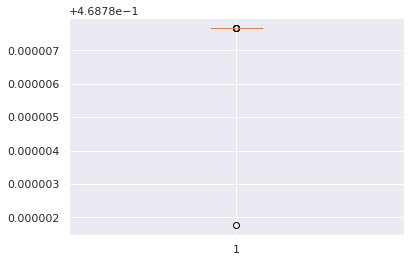

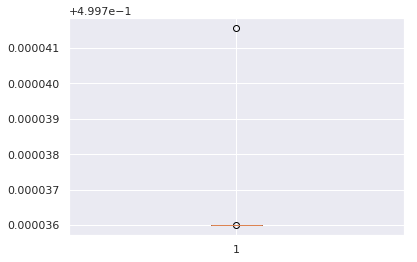

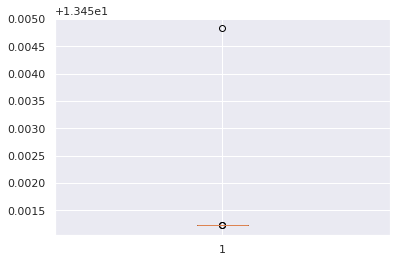

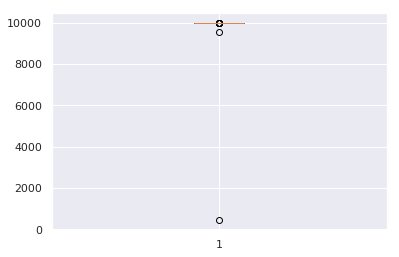

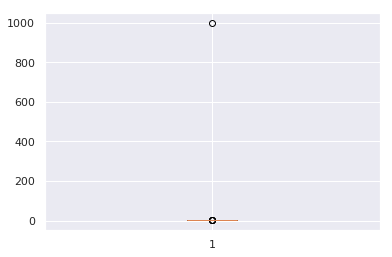

In [12]:
for i in range(5):
    plt.figure()
    plt.boxplot(lk2_params[0][:,i])
np.save('data/lk2_res_50_opts.npy', lk2_params[0])